# Analyze Model

How well does our trained model perform on unseen data? 

In [1]:
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np 
from scipy import stats

import os

# Loss Curve Analysis

Load the (directory of) losses

In [2]:
loss_dir = 'March 4th, 2024 (Time Series Prediction)'
loss_files = os.listdir(f'loss/{loss_dir}')

Load each loss curve, also keeping track of the particular instance

In [3]:
losses = {}
for loss in loss_files:
    with open(f'loss/{loss_dir}/{loss}', 'rb') as f:
        temp = pd.read_csv(f)
    losses[loss] = temp

Store the validation loss to quantify performance ... which one did the best? 

In [4]:
train_mse = {}
test_mse = {}

for loss in loss_files:

    train_mse[loss]=float(np.sqrt(losses[loss]['loss'].tail(1)))
    test_mse[loss]=float(np.sqrt(losses[loss]['val_loss'].tail(1)))

# What is the 'best performing' model?
    

C:\Users\tjaou104\AppData\Local\Temp\ipykernel_24460\2128013759.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  train_mse[loss]=float(np.sqrt(losses[loss]['loss'].tail(1)))
C:\Users\tjaou104\AppData\Local\Temp\ipykernel_24460\2128013759.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  test_mse[loss]=float(np.sqrt(losses[loss]['val_loss'].tail(1)))


In [5]:
train_mse

{'loss_timeSeriesPred_8200.csv': 0.02498297633275307}

Factoring in the Feburary 28 loss curves, this takes into account the variables 'solar_radiation', 'temperature', 'CN^2', 'Relative Humidity' ... maybe make a scatter plot? 

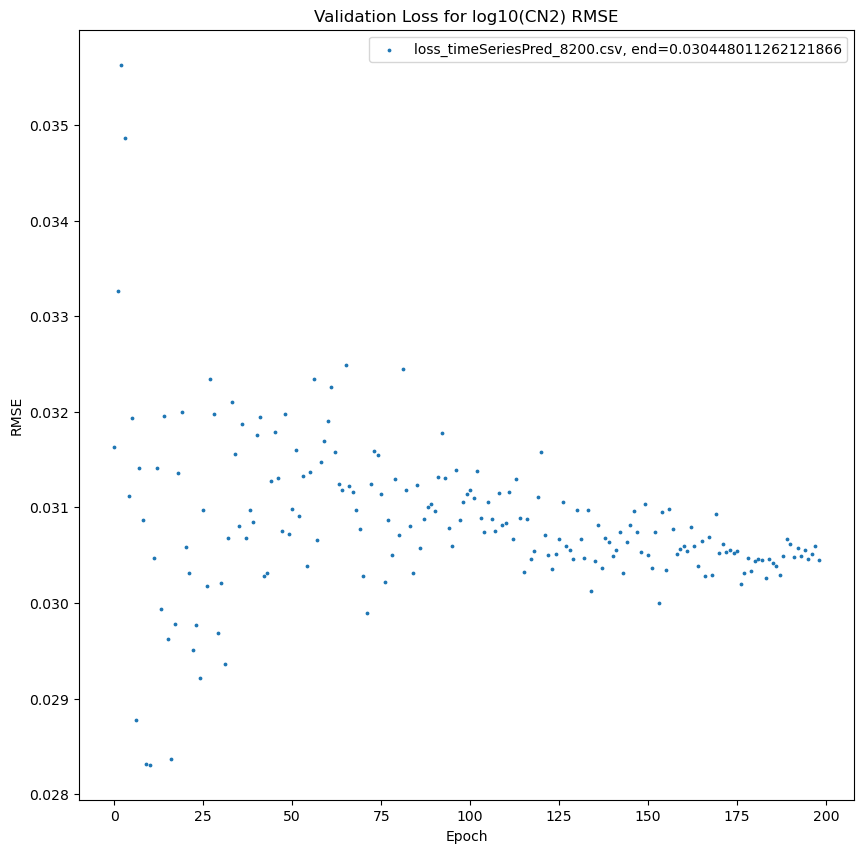

In [6]:
plt.figure(figsize=(10,10))
for ii, loss in enumerate(loss_files):
    y = np.sqrt(losses[loss]['val_loss'][:])
    epochs = np.arange(len(y))
    plt.scatter(epochs, y, s=3, label=f'{loss}, end={test_mse[loss]}')
    
plt.title('Validation Loss for log10(CN2) RMSE')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

Make a line plot similar to the paper

In [7]:
num_of_hours = [1,2,3,4,6,12]
tester_mse = [test_mse['loss_oneHour_7006.csv'], test_mse['loss_twoHour_3484.csv'],test_mse['loss_threeHour_6371.csv'], test_mse['loss_fourHour_7641.csv'], test_mse['loss_sixHour_1152.csv'], test_mse['loss_twelveHour_1654.csv']]  
plt.plot(num_of_hours, tester_mse, marker='o')

plt.xlabel('Number of Hours Ahead')
plt.ylabel('Validation RMSE on Log10(CN2)')

KeyError: 'loss_oneHour_7006.csv'

In [25]:
test_mse['loss_oneHour_7006.csv']

TypeError: list indices must be integers or slices, not str

# Testing Model Predictions

Choose input features

In [2]:
input_features = ['solar_radiation', 'relative_humidity', 'CN2',  'temperature']

Load the data

In [3]:
# Some useful functions

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data(x):
    minX = np.min(x)
    maxX = np.max(x)
    return (x - np.min(x))/(np.max(x) - np.min(x)), minX, maxX

# Routine to ... UNNORMALIZE. This is done to convert the data back to the original time scale. 

def unnorm_data(x, minX, maxX):
    unnorm_fac = (maxX - minX)
    return x*unnorm_fac + minX
    
# This applies a rolling average on the dataset 

# Function taken from a learnpython article

def roll_average(input_data, window_size):
    result = []
    for i in range(len(input_data) - window_size + 1):
        window = input_data[i:i+window_size]
        window_average = sum(window)/window_size
        result.append(window_average)
        
    return np.array(result)
    
def rollify_training(X, window_size):
    X_features = X.shape[2]
    
    X_roll_len = X.shape[1] - window_size + 1
    
    X_roll = np.empty((len(X), X_roll_len, X_features))
    
    for ii in range(len(X)):
        for jj in range(X_features):
            X_roll[ii,:,jj] = roll_average(X[ii,:,jj], window_size)
            
    return X_roll


def load_data(direc_name, time_steps, input_list, window_size, full_time_series=False, forecast_len=1):

    total_input = []
    total_output = []
    
    # Files expected
    
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    num_features = len(input_list)
    
    
    print(f'Parameter List: {input_list}')
    
    
    for ii, name in enumerate(directory_list):

        df = pd.read_csv(f'{direc_name}/{name}')
    
        dataset_weather = np.empty((time_steps, num_features))
        dataset_output = np.empty((forecast_len, 1))
        
        ###### INPUT DATA #######
        
        for ii, colName in enumerate(input_list):
            if(colName=='CN2'):
                dataset_weather[:,ii] = np.log10(df[colName].to_numpy())
            else:
                dataset_weather[:,ii] = df[colName].to_numpy()
            
        total_input.append(dataset_weather)
        
        ###### OUTPUT DATA #######
        
        # In the 0th output, CN2 FUTURE
        
        dataset_output[:,0] = np.log10(df["CN2 Future"][:forecast_len].to_numpy())

        total_output.append(dataset_output)
        
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    # Apply rolling average onto the input data
    total_input = rollify_training(total_input, window_size)
    
    
    # Apply normalization to each input entry
    for ii in range(num_features):
        total_input[:,:,ii],_,_ = norm_data(total_input[:,:,ii])
        
        
    # If we are working with time series prediction, apply rolling on output time series
    
    if (full_time_series):
        total_output = rollify_training(total_output, window_size)
        
        
    # Before normalizing: store information about the minimum and maximum of the CN^2 ... useful to apply the inverse operation
    
    # min_CN2, max_CN2 = min(total_output), max(total_output)
        
    # Apply normalization to each output entry
    total_output[:,:,0], minOut, maxOut = norm_data(total_output[:,:,0])
    
    
    # Finally, if we're working with a time series, let's pad out the output array with 0s
    
    if (full_time_series):
        window_time_steps_input = total_input.shape[1]
        window_time_steps_output = total_output.shape[1]
        
        total_output_padded = np.zeros((total_input.shape[0], window_time_steps_input, 1))
    
        total_output_padded[:,:window_time_steps_output, 0] = total_output[:,:,0]
        
        return total_input, total_output_padded, minOut, maxOut 
    else:
        return total_input, total_output
    
time_len = 12
direc_name = f"Batched Data/timeSeries{time_len}" # yaml worthy
sizeOfFiles = len([name for name in os.listdir(f'{direc_name}/.')]) # Global parameter

print(f"Number of files:{sizeOfFiles}")
train_factor = 0.90
val_factor = 0.15
num_of_examples = int(sizeOfFiles*train_factor)
X, y, minOut, maxOut = load_data(direc_name, 12, input_features, 3, True, time_len)
X_train, y_train = X[0:num_of_examples], y[0:num_of_examples]
X_test, y_test = X[num_of_examples::], y[num_of_examples::]

Number of files:2746
Parameter List: ['solar_radiation', 'relative_humidity', 'CN2', 'temperature']


In [4]:
hist, bins,_ = plt.hist(cn2_hist_train, bins=20)

NameError: name 'cn2_hist_train' is not defined

To give a sense of any possible bias within the training dataset, make a histogram of $CN^{2}$ values

In [ ]:
cn2_hist_train = 10**(unnorm_data(y_train.flatten(), minOut, maxOut))
cn2_hist_test = 10**(unnorm_data(y_test.flatten(), minOut, maxOut))

logbins = np.logspace(np.log10(1e-17),np.log10(5e-13), len(bins))

plt.hist(cn2_hist_train, bins=logbins, label = 'training CN2 values')
plt.hist(cn2_hist_test, bins=logbins, label = 'test CN2 values')
plt.xscale('log')
plt.legend()

Load trained model

In [26]:
# Model directories

# Week of March 4th Models
vinso_12_2 = 'timeSeries12_320Neurons_3Window_1310'
vinso_12 = 'timeSeries12_wider_5518'
vinso_9 = 'timeSeries9_4975'
vinso_6 = 'timeSeries6_8843'
vinso_3 = 'timeSeries3_4870'


# March 12th models
singleShot_12 = 'timeSeries12_singleShot_base_6691'
singleShot_9 = 'timeSeries9_singleShot_1319'
singleShot_6 = 'timeSeries6_singleShot_7836'
singleShot_biDirec = 'timeSeries12_base_bidirec_2662'


# Load the models

loaded_model_1 = tf.keras.models.load_model(f'models/{singleShot_biDirec}')
loaded_model_2 = tf.keras.models.load_model(f'models/{singleShot_12}')




For the time series, let's plot some predictions. Design a colormap based on the RMSE between points

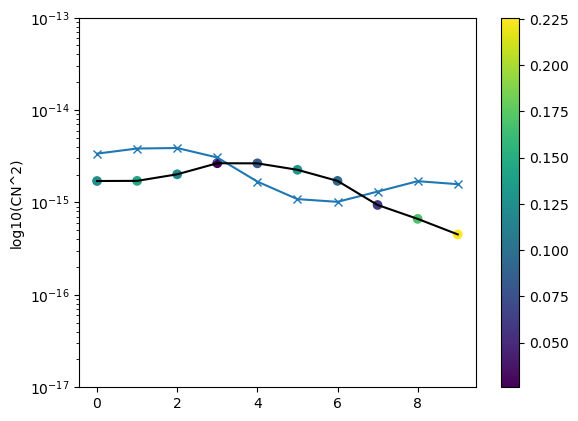

In [41]:
def rms(y_true, y_pred):
    root_mean = np.sqrt((y_true - y_pred)**2)
    return root_mean 

def rms_true(y_true, y_pred):
    root_mean = np.sqrt(np.mean((y_true - y_pred)**2))
    return root_mean

index = 30
X_test_pred = tf.expand_dims(X_test[index], axis=0)
ronso = loaded_model_2.predict(X_test_pred, verbose=False)
ronso = np.array(ronso[0]).flatten()
truth = np.array(y_test[index]).flatten()

error_gradient =rms(truth[:time_len], ronso[:time_len])
hrs = np.arange(time_len-2)

# For plotting, unnormalize

truth = 10**(unnorm_data(truth, minOut, maxOut))
ronso = 10**(unnorm_data(ronso, minOut, maxOut))

plt.plot(hrs, truth[:time_len-2], marker = 'x')
plt.scatter(hrs, ronso[:time_len-2] , c = error_gradient[:10], cmap='viridis', marker = 'o')
plt.plot(hrs, ronso[:time_len-2], color='black')
plt.colorbar()
plt.ylabel('log10(CN^2)')
plt.ylim(10**-17, 10**-13)
plt.yscale('log')


To compare performance between two models, let's make subplots showcasing both predictions 

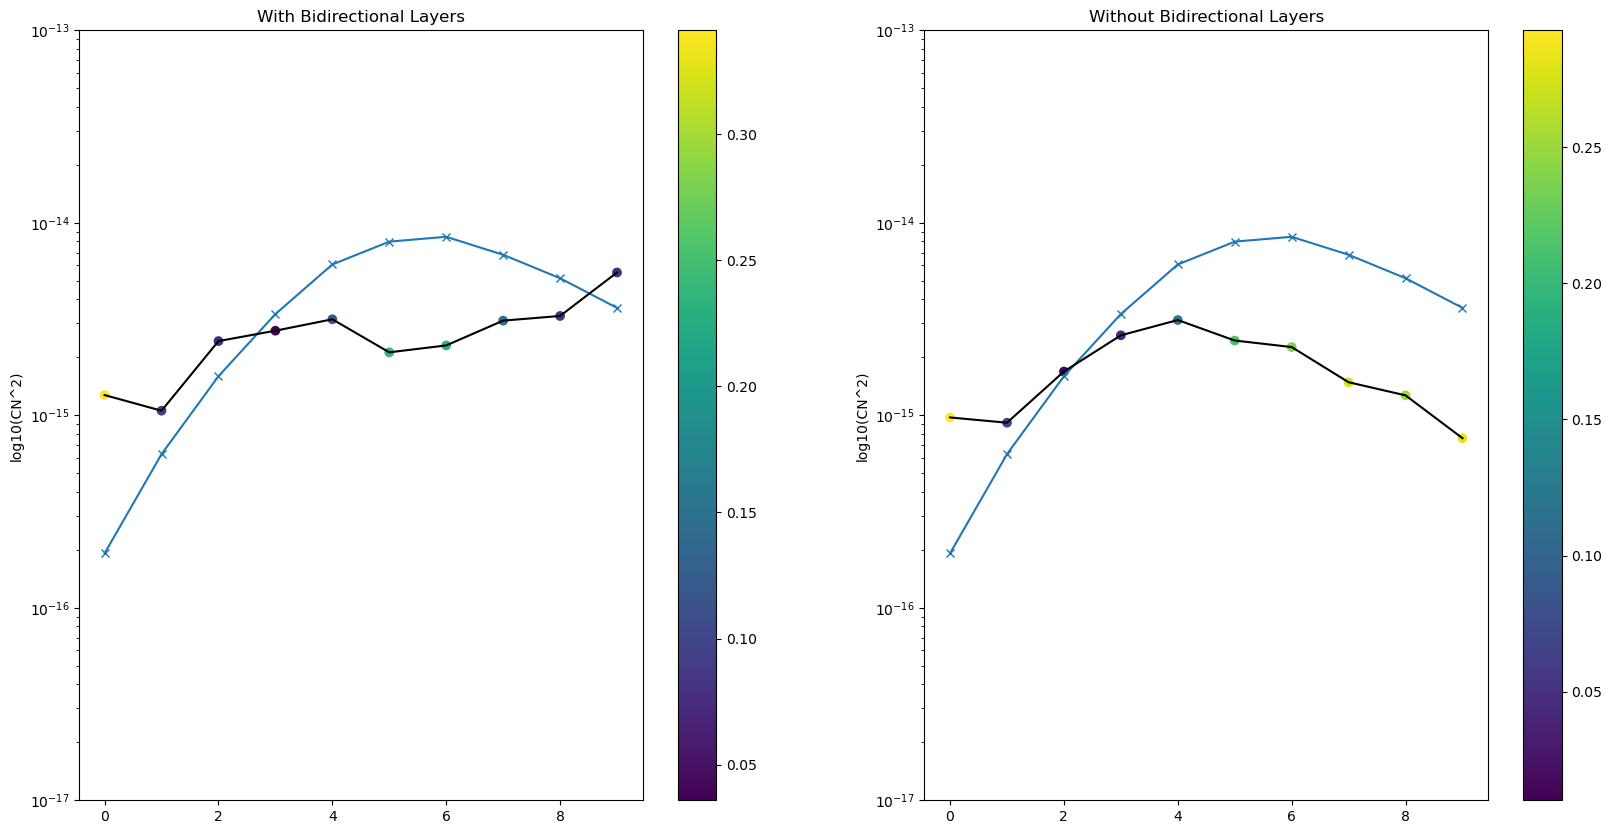

In [66]:
index = 48
X_test_pred = tf.expand_dims(X_test[index], axis=0)
ronso = loaded_model_1.predict(X_test_pred, verbose=False)
ronso = np.array(ronso[0]).flatten()
truth = np.array(y_test[index]).flatten()

error_gradient =rms(truth[:time_len], ronso[:time_len])
hrs = np.arange(time_len-2)

# For plotting, unnormalize
ronso_2 = loaded_model_2.predict(X_test_pred, verbose=False)
ronso_2 = np.array(ronso_2[0]).flatten()
error_gradient_2 = rms(truth[:time_len], ronso_2[:time_len])

# Unnormalize

truth = 10**(unnorm_data(truth, minOut, maxOut))
ronso = 10**(unnorm_data(ronso, minOut, maxOut))
ronso_2 = 10**(unnorm_data(ronso_2, minOut, maxOut))

# Make plots for both 

fig, ax = plt.subplots(1,2, figsize=(20,10))

ax[0].plot(hrs, truth[:time_len-2], marker = 'x')
im1 = ax[0].scatter(hrs, ronso[:time_len-2] , c = error_gradient[:10], cmap='viridis', marker = 'o')
ax[0].plot(hrs, ronso[:time_len-2], color='black')
cbar1 = plt.colorbar(im1, ax=ax[0])

ax[0].set_ylabel('log10(CN^2)')
ax[0].set_ylim(10**-17, 10**-13)
ax[0].set_yscale('log')
ax[0].set_title('With Bidirectional Layers')


ax[1].plot(hrs, truth[:time_len-2], marker = 'x')
im2 = ax[1].scatter(hrs, ronso_2[:time_len-2], c= error_gradient_2[:10])
ax[1].plot(hrs, ronso_2[:time_len-2], color='black')
cbar2 = plt.colorbar(im2, ax=ax[1])
ax[1].set_title('Without Bidirectional Layers')


ax[1].set_ylabel('log10(CN^2)')
ax[1].set_ylim(10**-17, 10**-13)
ax[1].set_yscale('log')


In [46]:
error_gradient

array([0.09251039, 0.02985922, 0.0699214 , 0.0422004 , 0.1086996 ,
       0.01658717, 0.03413432, 0.00078331, 0.04520079, 0.05858366])

In [30]:
ronso_2

array([6.0638334e-17, 6.0638334e-17, 6.0638334e-17, 6.0638334e-17,
       6.0638334e-17, 6.0638334e-17, 6.0638334e-17, 6.0638334e-17,
       6.0638334e-17, 6.0638334e-17], dtype=float32)

In [10]:
len(ronso)

10

Let's compute an overall metric ... how about computing the RMSE over the entire testing dataset? 

In [67]:
RMSEs = []
time_len_window = time_len - 2
for ii,x in enumerate(X_test):
    funky = tf.expand_dims(x, axis=0)
    preds = loaded_model_1.predict(funky, verbose=False)
    
    truth = np.array(y_test[ii]).flatten()
    preds = np.array(preds[0]).flatten()
    
    rmse = rms(truth[:time_len_window], preds[:time_len_window])
    RMSEs.append(rmse)
    
print(np.mean(RMSEs))

0.18402214993230082


In [68]:
print(np.mean(RMSEs))

0.18402214993230082


# Static Predictions

Plot model prediction vs. ground truths

In [64]:
model_predictions = []

for ii,x in enumerate(X_roll_test):
    print(ii)
    funky = tf.expand_dims(x, axis=0)
    preds = loaded_model.predict(funky, verbose=False)
    model_predictions.append(preds)
    
model_predictions = np.array(model_predictions)
Cn2_pred = model_predictions[:,0,0]
#r0_pred = model_predictions[:,0,1]

Cn2_true = y_test[:,0,0]
#r0_true = y_test[:,0,1]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Results on training data
Slope:1.113320864494608, intercept:-0.021167209522354943, r_value:0.8036351205908453


Text(0.5, 1.0, 'Ground Truths vs. Model Predictions -- $CN^2$\nR2 Value: 0.8036351205908453 -- Slope of Best Fit: 1.113320864494608')

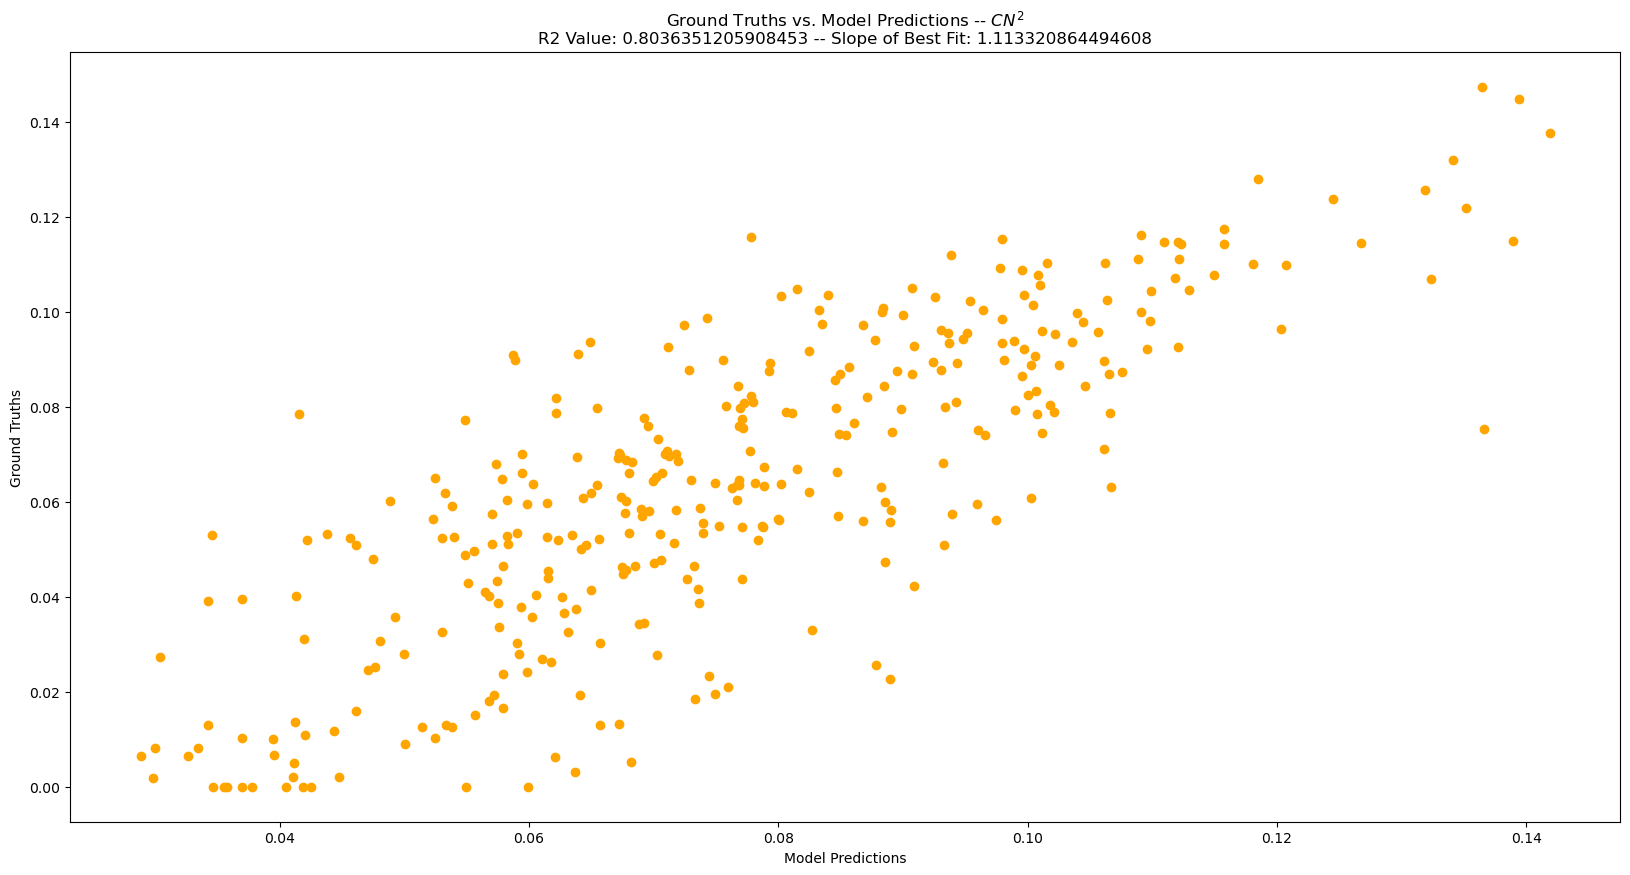

In [65]:
# Compute R2 value

slope_cn, intercept_cn, r_value_cn, p_value_cn, std_err_cn = stats.linregress(Cn2_pred, Cn2_true)

print("Results on training data")
print(f"Slope:{slope_cn}, intercept:{intercept_cn}, r_value:{r_value_cn}")

#slope_r0, intercept_r0, r_value_r0, p_value_r0, std_err_r0 = stats.linregress(r0_pred, r0_true)

#print("Results on training data")
#print(f"Slope:{slope_r0}, intercept:{intercept_r0}, r_value:{r_value_r0}")

fig, ax = plt.subplots(1,1, figsize=(20,10))


ax.scatter(Cn2_pred, Cn2_true, color='orange')
ax.set_xlabel('Model Predictions')
ax.set_ylabel('Ground Truths')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_title(f'Ground Truths vs. Model Predictions -- $CN^{2}$\nR2 Value: {r_value_cn} -- Slope of Best Fit: {slope_cn}')



#plt.savefig(f'R2Plots/{model_direc}.png', bbox_inches='tight')